In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchaudio
import torchaudio.transforms as transfroms
import soundfile as sf



Librosa is a python library for music and audio analysis

In [2]:
import librosa

array, sampling_rate = librosa.load(librosa.ex("trumpet")) 

The example is loaded as a tuple of audio time series (here we call it array), and sampling rate (sampling_rate). 



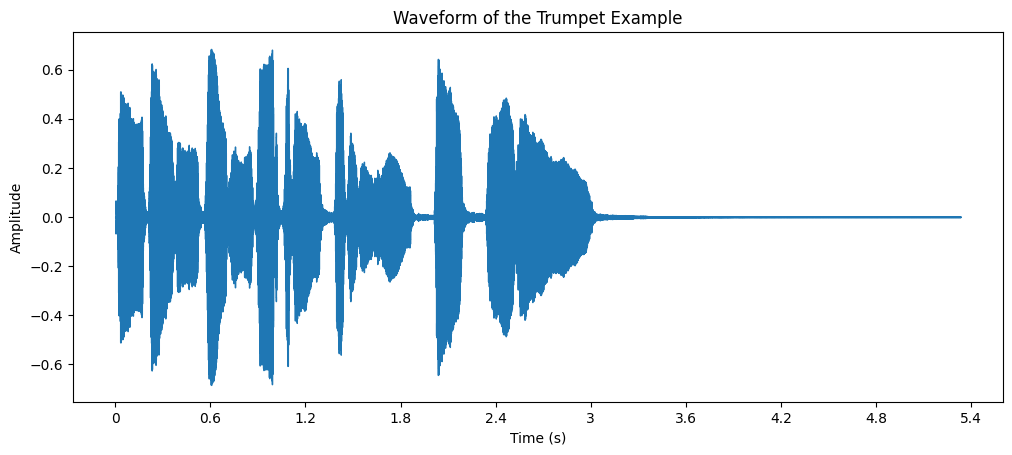

In [3]:
plt.figure().set_figwidth(12)


librosa.display.waveshow(array, sr=sampling_rate)
plt.title("Waveform of the Trumpet Example")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

load another dataset MINDS-14 which contains recordings of people asking an e-banking system questions in several languages and dialects.

In [4]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")    # just focussing on the australian accent and training set for now
minds

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [11]:
example  = minds[44]
example

{'path': 'C:\\Users\\prith\\.cache\\huggingface\\datasets\\downloads\\extracted\\314f2dbc8ae890a774c25100209f74960eb26f2ac5cabfb1e9c3fc0235db5610\\en-AU~PAY_BILL\\response_8.wav',
 'audio': {'path': 'C:\\Users\\prith\\.cache\\huggingface\\datasets\\downloads\\extracted\\314f2dbc8ae890a774c25100209f74960eb26f2ac5cabfb1e9c3fc0235db5610\\en-AU~PAY_BILL\\response_8.wav',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00048828,
         -0.00048828,  0.00048828]),
  'sampling_rate': 8000},
 'transcription': 'hi ID like to make a payment with my bank account',
 'english_transcription': 'hi ID like to make a payment with my bank account',
 'intent_class': 13,
 'lang_id': 2}

here 
array: is the decoded audio data in 1d numpy format
(array, sampling_rate are inside the audio category accessed as done below)

The intent_class: is a classification category of the audio recording. To convert this number into a meaningful string, we can use the int2str() method

audio : is the original spoken audio


In [12]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [14]:
# remove irrelavant features like lang id and english translation 

columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

 U can listen to audio using Gradio


In [16]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(2):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

c:\Python 3.10\lib\site-packages\gradio\processing_utils.py:582: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


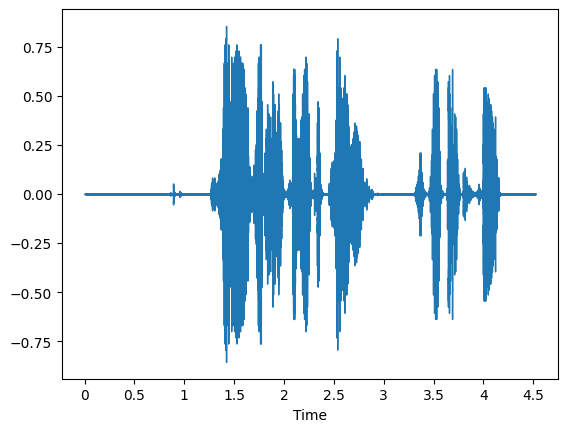

In [18]:
array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

librosa.display.waveshow(array,sr=sampling_rate)

Preprocessing Audio Data :-

1.Resampling

2.Filtering the dataset

3.Converting audio data to models input

In [19]:
# audio sampling rate generally in most datasets is 16kHz, here it was 8 Khz so we need to increase the sampling 
# rate

from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [20]:
minds[0]

{'path': 'C:\\Users\\prith\\.cache\\huggingface\\datasets\\downloads\\extracted\\314f2dbc8ae890a774c25100209f74960eb26f2ac5cabfb1e9c3fc0235db5610\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\prith\\.cache\\huggingface\\datasets\\downloads\\extracted\\314f2dbc8ae890a774c25100209f74960eb26f2ac5cabfb1e9c3fc0235db5610\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([2.36120541e-05, 1.92325111e-04, 2.19284673e-04, ...,
         9.40908678e-04, 1.16613181e-03, 7.20883720e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

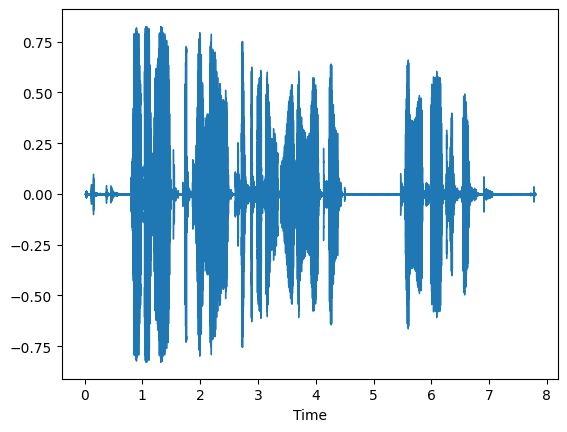

In [21]:
array = minds[0]["audio"]["array"]
sampling_rate = minds[0]["audio"]["sampling_rate"]


librosa.display.waveshow(array,sr=sampling_rate)

In [22]:
# Filter the dataset to 20s

MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS



new_column = [librosa.get_duration(path=x) for x in minds["path"]]        # adds a duration column with each input 
minds = minds.add_column("duration", new_column)


minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])     # filter method filters based on true and false values


minds = minds.remove_columns(["duration"])
minds

c:\Python 3.10\lib\site-packages\datasets\table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

No of rows decreased to 624 : inputs that were longer than 20s were removed

WHISPER is a pre-trained ASR model published in Sep'22 by OpenAI :-

it pads or truncates every input to 30s.
pads by appending zeros in the sequence - zeros mean silence in audio.

Whisper is trained to operate without an ATTENTION MASK and infer directly from the speech signals where to ignore the inputs.

All these transformations can be applied to your raw audio data:-





In [23]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

c:\Python 3.10\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\prith\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  


Next, you can write a function to pre-process a single audio example by passing it through the feature_extractor.


We can apply the data preparation function to all of our training examples using huggingface Datasets’ map method:



In [25]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

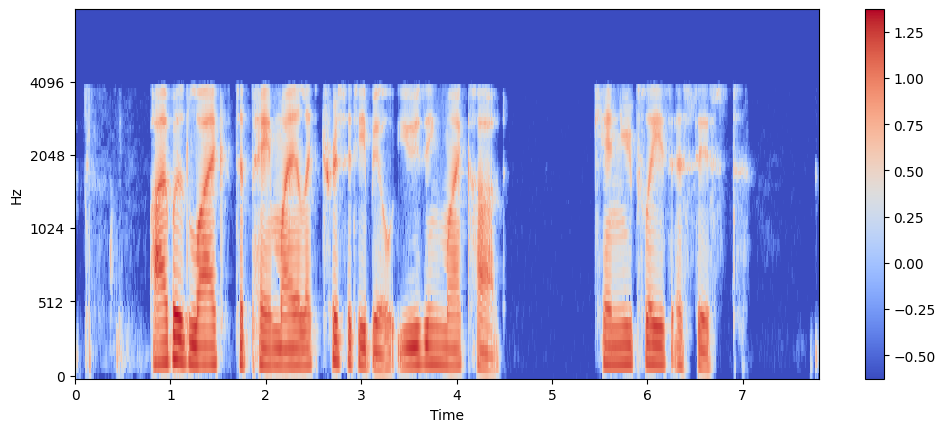

In [28]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

streaming the dataset : usually datasets are thousands of hours long and hence exceed the size of Hard disks and hence we stream data i.e. iterating over the dataset input by input.

for this just do streaming = true while loading the dataset.



In [29]:
#gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

The only difference is that you can no longer access individual samples using Python indexing (i.e. gigaspeech["train"][sample_idx]). Instead, you have to iterate over the dataset. Here’s how you can access an example when streaming a dataset

ex:-
next(iter(gigaspeech["train"]))

If you’d like to preview several examples from a large dataset, use the take() to get the first n elements. Let’s grab the first two examples in the gigaspeech dataset:

ex:-
gigaspeech_head = gigaspeech["train"].take(2)
list(gigaspeech_head)